# Ejercicio 4 — Agrupamiento de flores con ResNet50, PCA y KMeans

## Objetivo
Agrupar 500 imágenes de diferentes tipos de flores en **5 grupos** utilizando sus características visuales. Para ello empleamos una red neuronal convolucional preentrenada (**ResNet50**), reducción de dimensionalidad con **PCA** y un algoritmo de **clustering** (*KMeans*).  

## Metodología
1. **Preparación del entorno**  
   Definimos flags de ejecución, rutas y estructura de carpetas. Importamos las librerías necesarias y configuramos el estilo de gráficos.
2. **Carga y verificación de datos**  
   Contamos y revisamos las imágenes presentes en `data/flores/`, comprobando formatos y tamaño.
3. **Extracción de características**  
   Usamos **ResNet50** (`include_top=False`, `pooling='avg'`) para obtener vectores de ≈2048 dimensiones por imagen, tras el *preprocessing* correspondiente.
4. **Reducción de dimensionalidad (PCA)**  
   Calculamos la varianza explicada y elegimos un número óptimo de componentes para representar las imágenes de forma compacta.
5. **Clustering (KMeans)**  
   Agrupamos las imágenes en 5 clusters usando KMeans sobre las componentes principales.
6. **Evaluación cualitativa**  
   Seleccionamos 5 imágenes aleatorias por cluster y observamos la coherencia visual dentro de cada grupo.
7. **Visualización**  
   Representamos en 2D (PC1 y PC2) las imágenes coloreadas según el cluster asignado.
8. **Conclusiones**  
   Resumimos la coherencia de los grupos, limitaciones y posibles mejoras.

## Salidas
- **CSV** en `outputs/csv/` con etiquetas y métricas.
- **Modelos** (`pca.pkl`, `kmeans.pkl`) en `outputs/models/`.
- **Figuras** (varianza PCA, scatter 2D, mosaicos) en `outputs/figures/`.

## 1.Preparación del entorno

En esta primera parte configuramos el entorno de trabajo de forma **portable**, para que el mismo notebook pueda ejecutarse tanto en **Google Drive** como en local.  
Para ello definimos dos banderas clave:

- **`USE_DRIVE`**: indica si trabajamos con archivos en Google Drive (`True`) o en local para la entrega(`False`).
- **`RUN_MODELING`**: determina si se entrenan y generan artefactos (`True`) o si se cargan resultados ya guardados (`False`) en el modo entrega.

Además:
- Definimos la **estructura de carpetas** para el ejercicio, incluyendo directorios para datos, modelos, salidas y documentación.
- Importamos todas las **librerías necesarias** en una única celda.
- Establecemos un **estilo gráfico consistente** para todas las visualizaciones.
- Creamos un archivo `README.md` con instrucciones básicas para reutilizar y comprender el proyecto.


In [9]:
# 1) Preparación del entorno (portable): flags, rutas, imports y estilo

# === Flags ===
USE_DRIVE   = False   # Trabajo habitual en Drive (entrega → False)
RUN_MODELING = False  # Generar artefactos (entrega → False, solo cargar)

# === Imports únicos ===
import os,io, glob, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

# === Estilo de gráficos (consistente) ===
plt.rcParams.update({
    "figure.figsize": (8, 4),
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
})
plt.style.use("default")

# === Rutas y estructura ===
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT = Path("/content/drive/MyDrive/MASTER BIG DATA/md2_2025")
    EJ4  = ROOT / "ej4_clustering_flores"
else:
    here = Path(".").resolve()
    EJ4  = here if here.name == "ej4_clustering_flores" else (here / "ej4_clustering_flores")

PATHS = {
    "ej4":        str(EJ4),
    "nb":         str(EJ4 / "notebooks"),
    "src":        str(EJ4 / "src"),
    "data":       str(EJ4 / "data" / "flores"),
    "out_csv":    str(EJ4 / "outputs" / "csv"),
    "out_figs":   str(EJ4 / "outputs" / "figures"),
    "out_models": str(EJ4 / "outputs" / "models"),
    "docs":       str(EJ4 / "docs"),
    "scripts":    str(EJ4 / "scripts"),
}

def ensure_dir(p: str): Path(p).mkdir(parents=True, exist_ok=True)
for k in ("nb","src","data","out_csv","out_figs","out_models","docs","scripts"):
    ensure_dir(PATHS[k])

# README
readme = Path(PATHS["ej4"]) / "README.md"
if not readme.exists():
    readme.write_text("""# Ejercicio 4 — Clustering de flores (ResNet50 → PCA → KMeans)
Este proyecto tiene como objetivo **agrupar 500 imágenes de flores en 5 grupos** según sus características visuales.
Para ello utilizamos una red neuronal convolucional **ResNet50** preentrenada para extraer vectores de características, reducimos la dimensionalidad con **PCA** y aplicamos un algoritmo de **clustering KMeans** para generar los grupos.

**Datos (no incluidos en el ZIP):** colocar imágenes en `data/flores/` (formatos JPG/PNG).
**Modo trabajo:** `USE_DRIVE=True`, `RUN_MODELING=True` para generar artefactos.
**Modo entrega:** `USE_DRIVE=False`, `RUN_MODELING=False` para cargar artefactos desde `outputs/`.

**Salidas:**
- `outputs/csv/`     → features index, etiquetas de KMeans, métricas básicas.
- `outputs/models/`  → `pca.pkl`, `kmeans_k5.pkl`.
- `outputs/figures/` → varianza PCA, scatter 2D, mosaicos por cluster.
""", encoding="utf-8")

print("Flags → USE_DRIVE =", USE_DRIVE, "| RUN_MODELING =", RUN_MODELING)
print("Rutas clave:")
for k in ("data","out_csv","out_figs","out_models","docs"):
    print(f"  {k:>10} → {PATHS[k]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Flags → USE_DRIVE = True | RUN_MODELING = True
Rutas clave:
        data → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej4_clustering_flores/data/flores
     out_csv → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej4_clustering_flores/outputs/csv
    out_figs → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej4_clustering_flores/outputs/figures
  out_models → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej4_clustering_flores/outputs/models
        docs → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej4_clustering_flores/docs


## 2.Carga y verificación de datos

En este paso revisamos que las imágenes estén correctamente ubicadas en `data/flores/` y que sean legibles.  
Nuestro objetivo es construir un **índice de imágenes** con la información mínima necesaria para el resto del flujo:

- Ruta relativa y nombre de archivo.  
- Formato/Extensión y tamaño en bytes.  
- Dimensiones (ancho y alto) y **aspect ratio**.  
- Indicador de si la imagen es **legible** (para detectar corruptas).

Guardaremos este índice en `outputs/csv/images_index.csv`.
  
Además, mostraremos una **muestra aleatoria** de imágenes para validar visualmente que los datos son coherentes.

Imágenes encontradas: 503
Legibles: 503 | No legibles: 0
Distribución por extensión: {'.jpg': 503}


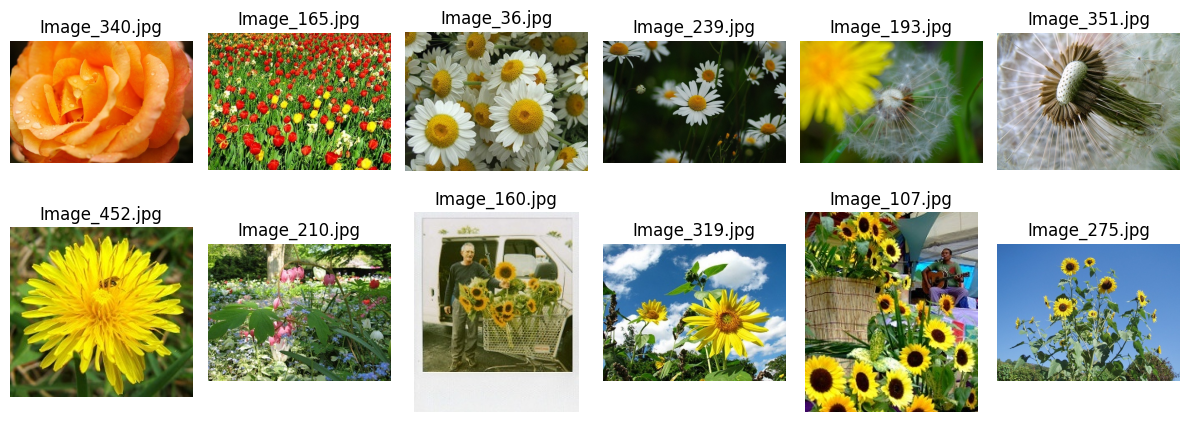

Figura de muestra guardada en: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej4_clustering_flores/outputs/figures/muestra_imagenes.png


In [3]:
# 2) Carga y verificación de datos: índice de imágenes + muestra visual
# --- Configuración ---
DATA_DIR = Path(PATHS["data"])
OUT_CSV  = Path(PATHS["out_csv"])
OUT_FIGS = Path(PATHS["out_figs"])
OUT_CSV.mkdir(parents=True, exist_ok=True)
OUT_FIGS.mkdir(parents=True, exist_ok=True)

VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
INDEX_CSV  = OUT_CSV / "images_index.csv"
SAMPLE_FIG = OUT_FIGS / "muestra_imagenes.png"

# --- Recolección de ficheros ---
all_files = [p for p in DATA_DIR.rglob("*") if p.suffix.lower() in VALID_EXTS]

# --- Función de análisis seguro de imagen ---
def probe_image(path: Path):
    info = {
        "filepath": str(path),
        "filename": path.name,
        "ext": path.suffix.lower(),
        "size_bytes": None,
        "width": None,
        "height": None,
        "aspect": None,
        "is_readable": False
    }
    try:
        info["size_bytes"] = path.stat().st_size
        with Image.open(path) as im:
            im.verify()  # Verificación rápida
        # Reabrimos para obtener dimensiones (verify cierra el archivo)
        with Image.open(path) as im2:
            w, h = im2.size
            info["width"] = int(w)
            info["height"] = int(h)
            info["aspect"] = round(w / h, 4) if (w and h) else None
            info["is_readable"] = True
    except Exception:
        info["is_readable"] = False
    return info

# --- Construcción del índice ---
records = [probe_image(p) for p in sorted(all_files)]
df_idx = pd.DataFrame.from_records(records)

# --- Guardado del índice ---
df_idx.to_csv(INDEX_CSV, index=False, encoding="utf-8")

# --- Resumen por pantalla ---
total = len(df_idx)
legibles = int(df_idx["is_readable"].sum())
no_legibles = total - legibles
ext_counts = df_idx["ext"].value_counts().to_dict()

print(f"Imágenes encontradas: {total}")
print(f"Legibles: {legibles} | No legibles: {no_legibles}")
print("Distribución por extensión:", ext_counts)
if total == 0:
    print("No se han encontrado imágenes en la carpeta:", DATA_DIR)

# --- Muestra visual aleatoria (opcional pero útil) ---
def mostrar_muestra(df, n=12, cols=6):
    df_ok = df[df["is_readable"]].copy()
    if len(df_ok) == 0:
        print("No hay imágenes legibles para mostrar.")
        return
    sample = df_ok.sample(min(n, len(df_ok)), random_state=42)
    rows = int(np.ceil(len(sample) / cols))

    plt.figure(figsize=(cols * 2, rows * 2.2))
    for i, (_, row) in enumerate(sample.iterrows(), start=1):
        try:
            with Image.open(row["filepath"]) as im:
                plt.subplot(rows, cols, i)
                plt.imshow(im)
                plt.axis("off")
                plt.title(row["filename"][:30])
        except Exception:
            # Si alguna falla al abrir ahora, la saltamos
            continue
    plt.tight_layout()
    plt.savefig(SAMPLE_FIG, dpi=120, bbox_inches="tight")
    plt.show()
    print("Figura de muestra guardada en:", SAMPLE_FIG)

# Mostrar una cuadrícula de muestra para inspección rápida
mostrar_muestra(df_idx, n=12, cols=6)

## 3.Extracción de características con ResNet50

En este paso utilizamos la red neuronal convolucional **ResNet50** preentrenada en ImageNet para convertir cada imagen en un **vector de características** que la represente.

- **Arquitectura**: cargamos ResNet50 con `include_top=False` para excluir la capa de clasificación original y con `pooling='avg'` para obtener un único vector de características por imagen mediante *global average pooling*.
- **Preprocesado**: las imágenes se redimensionan a **224×224 píxeles** y se procesan con `preprocess_input` para adaptarlas al formato esperado por el modelo.
- **Salida**: cada imagen se transforma en un vector de **2048 dimensiones** que captura información visual relevante.
- **Artefactos**:
  - Guardamos la matriz de características en `outputs/csv/features_resnet50.csv`.
  - Guardamos el modelo ResNet50 en memoria para posibles inferencias posteriores.
  
Si `RUN_MODELING=False`, cargaremos las características directamente desde el CSV guardado para evitar recomputarlas.

In [5]:
# 3) Extracción de características con ResNet50 preentrenada

FEATURES_CSV = Path(PATHS["out_csv"]) / "features_resnet50.csv"

if RUN_MODELING:
    # --- Cargar modelo ResNet50 sin la capa de clasificación ---
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    # --- Filtrar solo imágenes legibles del índice ---
    df_idx = pd.read_csv(Path(PATHS["out_csv"]) / "images_index.csv")
    df_ok  = df_idx[df_idx["is_readable"]].reset_index(drop=True)

    features_list = []

    print(f"Extrayendo características de {len(df_ok)} imágenes...")
    for img_path in tqdm(df_ok["filepath"], total=len(df_ok)):
        # Cargar imagen y redimensionar a 224x224
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Extraer características
        feats = base_model.predict(x, verbose=0)
        features_list.append(feats.flatten())

    # Convertir a DataFrame
    features_array = np.array(features_list)
    df_features = pd.DataFrame(features_array)
    df_features.insert(0, "filepath", df_ok["filepath"])

    # Guardar características
    df_features.to_csv(FEATURES_CSV, index=False, encoding="utf-8")
    print("Características guardadas en:", FEATURES_CSV)

else:
    # --- Cargar características previamente guardadas ---
    df_features = pd.read_csv(FEATURES_CSV)
    print("Características cargadas desde:", FEATURES_CSV)

print("Shape de matriz de características:", df_features.shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Extrayendo características de 503 imágenes...


100%|██████████| 503/503 [00:55<00:00,  9.02it/s]


Características guardadas en: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej4_clustering_flores/outputs/csv/features_resnet50.csv
Shape de matriz de características: (503, 2049)


Hemos obtenido una matriz de características de 2048 dimensiones por imagen, que servirá como base para la reducción de dimensionalidad con PCA en el siguiente paso

## 4.Reducción de dimensionalidad con PCA

La matriz de características obtenida con ResNet50 tiene **2048 dimensiones**, lo que dificulta el análisis y puede introducir ruido.  
Para simplificar y facilitar el agrupamiento, aplicamos **Análisis de Componentes Principales (PCA)**:

1. **Cálculo de la varianza explicada** por cada componente principal.
2. **Selección del número óptimo de componentes**:
   - Usamos el criterio de **varianza acumulada ≥ 90%** como referencia.
   - También observamos el **codo** en la gráfica de varianza acumulada.
3. **Transformación de los datos** a un espacio reducido con el número de componentes elegido.

Guardamos:
- `pca.pkl` en `outputs/models/` con el modelo PCA entrenado.
- `features_pca.csv` en `outputs/csv/` con las características reducidas.

Si `RUN_MODELING=False`, cargaremos directamente estos artefactos para no recalcular el PCA.

Componentes que explican ≥90% de varianza: 162


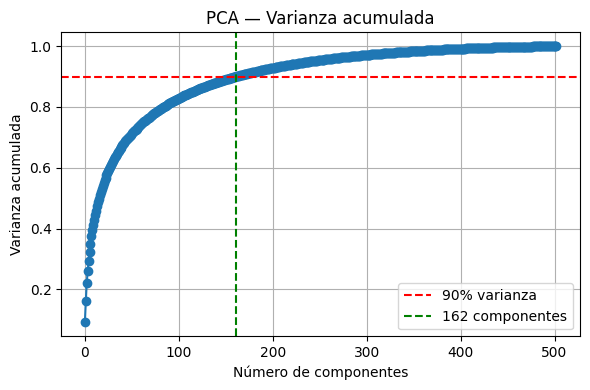

Modelo PCA guardado en: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej4_clustering_flores/outputs/models/pca.pkl
Características reducidas guardadas en: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej4_clustering_flores/outputs/csv/features_pca.csv
Shape después de PCA: (503, 163)


In [6]:
# 4) Reducción de dimensionalidad con PCA
PCA_MODEL_PATH = Path(PATHS["out_models"]) / "pca.pkl"
PCA_CSV_PATH   = Path(PATHS["out_csv"]) / "features_pca.csv"
PCA_FIG_PATH   = Path(PATHS["out_figs"]) / "pca_varianza.png"

if RUN_MODELING:
    # Cargar características ResNet50
    df_features = pd.read_csv(Path(PATHS["out_csv"]) / "features_resnet50.csv")
    X = df_features.drop(columns=["filepath"]).values

    # PCA sin limitar componentes (para analizar varianza explicada)
    pca_full = PCA()
    pca_full.fit(X)

    # Calcular varianza acumulada
    var_exp_acum = np.cumsum(pca_full.explained_variance_ratio_)
    n_components_opt = np.argmax(var_exp_acum >= 0.90) + 1  # primera que supera 90%

    print(f"Componentes que explican ≥90% de varianza: {n_components_opt}")

    # Entrenar PCA definitivo con n_components_opt
    pca = PCA(n_components=n_components_opt)
    X_pca = pca.fit_transform(X)

    # Guardar modelo y datos transformados
    joblib.dump(pca, PCA_MODEL_PATH)
    df_pca = pd.DataFrame(X_pca)
    df_pca.insert(0, "filepath", df_features["filepath"])
    df_pca.to_csv(PCA_CSV_PATH, index=False, encoding="utf-8")

    # Gráfico de varianza acumulada
    plt.figure(figsize=(6,4))
    plt.plot(var_exp_acum, marker='o')
    plt.axhline(y=0.90, color='r', linestyle='--', label='90% varianza')
    plt.axvline(x=n_components_opt-1, color='g', linestyle='--',
                label=f'{n_components_opt} componentes')
    plt.xlabel("Número de componentes")
    plt.ylabel("Varianza acumulada")
    plt.title("PCA — Varianza acumulada")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(PCA_FIG_PATH, dpi=120)
    plt.show()

    print("Modelo PCA guardado en:", PCA_MODEL_PATH)
    print("Características reducidas guardadas en:", PCA_CSV_PATH)

else:
    # Cargar artefactos ya guardados
    pca = joblib.load(PCA_MODEL_PATH)
    df_pca = pd.read_csv(PCA_CSV_PATH)
    print("PCA cargado desde:", PCA_MODEL_PATH)
    print("Características reducidas cargadas desde:", PCA_CSV_PATH)

print("Shape después de PCA:", df_pca.shape)

**Conclusión del PCA**  
La reducción de dimensionalidad con PCA ha permitido pasar de 2048 a **162 componentes** que explican al menos el **90 % de la varianza total**.  
Este resultado mantiene la mayor parte de la información relevante de las imágenes, a la vez que simplifica el espacio de trabajo y reduce el coste computacional de los pasos posteriores.  
La elección de 162 componentes se justifica por el criterio de varianza acumulada ≥ 90 % y se confirma visualmente en la gráfica de varianza acumulada.

## 5.Clustering con KMeans

Con las características reducidas por PCA aplicamos el algoritmo de **KMeans** para agrupar las imágenes en **5 clusters**:

- **Datos de entrada**: matriz PCA (162 componentes) obtenida en el paso anterior.
- **Parámetros del modelo**:
  - `n_clusters=5` según el enunciado del ejercicio.
  - `random_state=42` para reproducibilidad.
  - `n_init=10` para mejorar la estabilidad de los resultados.
- **Evaluación**:
  - Calculamos el **Silhouette Score**, que mide la separación entre clusters (valores cercanos a 1 indican mejor separación).
- **Salidas**:
  - Guardamos el modelo `kmeans_k5.pkl` en `outputs/models/`.
  - Guardamos un CSV `clusters_k5.csv` en `outputs/csv/` con la ruta de la imagen y el cluster asignado.

In [7]:
# 5) Clustering con KMeans

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import pandas as pd

KMEANS_MODEL_PATH = Path(PATHS["out_models"]) / "kmeans_k5.pkl"
CLUSTERS_CSV_PATH = Path(PATHS["out_csv"]) / "clusters_k5.csv"

if RUN_MODELING:
    # Cargar datos reducidos por PCA
    df_pca = pd.read_csv(Path(PATHS["out_csv"]) / "features_pca.csv")
    X_pca = df_pca.drop(columns=["filepath"]).values

    # Entrenar KMeans
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)

    # Calcular Silhouette Score
    sil_score = silhouette_score(X_pca, labels)
    print(f"Silhouette Score (k=5): {sil_score:.4f}")

    # Guardar modelo
    joblib.dump(kmeans, KMEANS_MODEL_PATH)

    # Guardar asignaciones de cluster
    df_clusters = pd.DataFrame({
        "filepath": df_pca["filepath"],
        "cluster": labels
    })
    df_clusters.to_csv(CLUSTERS_CSV_PATH, index=False, encoding="utf-8")

else:
    # Cargar artefactos guardados
    kmeans = joblib.load(KMEANS_MODEL_PATH)
    df_clusters = pd.read_csv(CLUSTERS_CSV_PATH)
    print("KMeans cargado desde:", KMEANS_MODEL_PATH)

print("Clusters asignados. Shape:", df_clusters.shape)

Silhouette Score (k=5): 0.0734
Clusters asignados. Shape: (503, 2)


El *Silhouette Score* obtenido (**0.0734**) indica que los clusters presentan un solapamiento considerable, algo esperado en un problema no supervisado con imágenes visualmente similares.  
Aun así, el modelo nos servirá como base para la evaluación cualitativa mediante inspección visual de ejemplos representativos en el siguiente paso.

## 6.Evaluación cualitativa de clusters

En este paso seleccionamos aleatoriamente **5 imágenes por cada cluster** y las mostramos en forma de mosaico.  
El objetivo es comprobar de manera visual si las imágenes agrupadas comparten ciertas características (colores, formas, tipos de flores, etc.) que justifiquen su pertenencia al mismo grupo.  

Este análisis no cuantitativo es fundamental en problemas de *clustering* de imágenes, ya que puede revelar patrones que las métricas numéricas no detectan.

In [8]:
# 6) Evaluación cualitativa: muestra de 5 imágenes por cluster

# Cargar asignaciones de cluster
df_clusters = pd.read_csv(Path(PATHS["out_csv"]) / "clusters_k5.csv")

# Carpeta para guardar mosaicos
mosaic_dir = Path(PATHS["out_figs"])
mosaic_dir.mkdir(parents=True, exist_ok=True)

def mostrar_mosaico_cluster(cluster_id, n=5):
    subset = df_clusters[df_clusters["cluster"] == cluster_id]
    sample_paths = subset.sample(min(n, len(subset)), random_state=42)["filepath"].tolist()

    fig, axes = plt.subplots(1, len(sample_paths), figsize=(len(sample_paths) * 3, 3))
    if len(sample_paths) == 1:
        axes = [axes]  # Garantizar que axes sea iterable

    for ax, img_path in zip(axes, sample_paths):
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"Cluster {cluster_id}")
        except Exception as e:
            ax.axis("off")
            ax.set_title("Error")
    plt.tight_layout()
    output_path = mosaic_dir / f"muestra_cluster_{cluster_id}.png"
    plt.savefig(output_path, dpi=120)
    plt.show()
    print(f"Mosaico guardado en: {output_path}")

# Mostrar mosaicos para cada cluster
for c in sorted(df_clusters["cluster"].unique()):
    mostrar_mosaico_cluster(c, n=5)

Output hidden; open in https://colab.research.google.com to view.

**Conclusión de la evaluación cualitativa**  

Los resultados confirman que, a pesar de la baja separación cuantitativa, el modelo ha captado patrones visuales relevantes en las imágenes:

- **Cluster 0**: predominio de girasoles y flores amarillas en entornos naturales.  
- **Cluster 1**: flores de diente de león, tanto en color como en blanco y negro.  
- **Cluster 2**: flores rojas o anaranjadas, principalmente tulipanes y rosas.  
- **Cluster 3**: escenas de campos floridos, con predominio de tonos rosas y morados.  
- **Cluster 4**: flores con morfología de margarita, caracterizadas por pétalos alargados dispuestos radialmente y un centro circular prominente, independientemente de su color .  


## 7.Visualización 2D de los clusters

Para complementar la evaluación cualitativa, representamos cada imagen en el plano definido por las dos primeras componentes principales del PCA (**PC1** y **PC2**).  
Cada punto corresponde a una imagen y está coloreado según el cluster asignado por KMeans.

Esta visualización permite:
- Observar si existen grupos claramente separados en el espacio reducido.
- Detectar posibles solapamientos entre clusters.
- Analizar si los patrones visuales detectados se reflejan en la distribución geométrica de los datos.

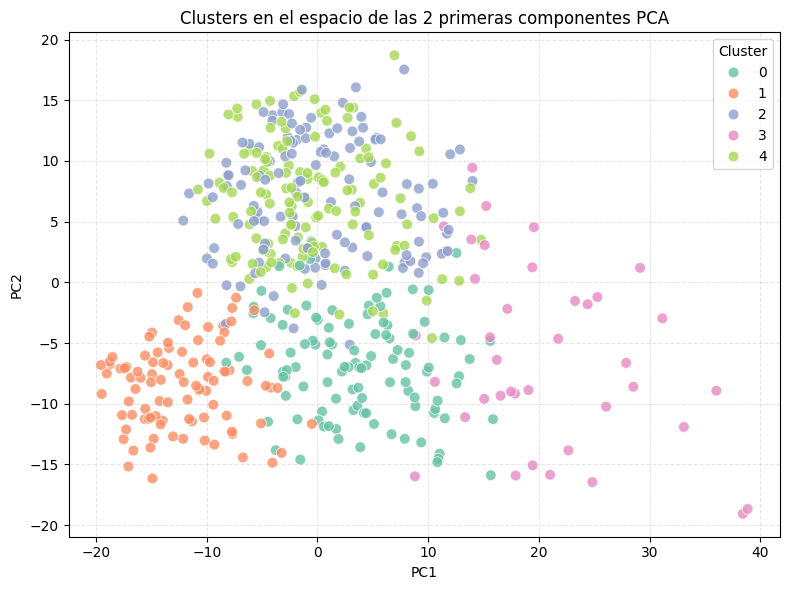

Gráfico 2D guardado en: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej4_clustering_flores/outputs/figures/pca_clusters_2d.png


In [10]:
# 7) Visualización 2D de clusters en el espacio PCA

PCA_CSV_PATH = Path(PATHS["out_csv"]) / "features_pca.csv"
CLUSTERS_CSV_PATH = Path(PATHS["out_csv"]) / "clusters_k5.csv"
PCA_SCATTER_PATH = Path(PATHS["out_figs"]) / "pca_clusters_2d.png"

# Cargar datos PCA y clusters
df_pca = pd.read_csv(PCA_CSV_PATH)
df_clusters = pd.read_csv(CLUSTERS_CSV_PATH)

# Combinar dataframes
df_vis = df_pca.copy()
df_vis["cluster"] = df_clusters["cluster"]

# Seleccionar solo las dos primeras componentes
df_vis_2d = df_vis.rename(columns={df_vis.columns[1]: "PC1", df_vis.columns[2]: "PC2"})

# Gráfico de dispersión
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_vis_2d,
    x="PC1", y="PC2",
    hue="cluster",
    palette="Set2",
    s=60,
    alpha=0.8,
    edgecolor="w"
)
plt.title("Clusters en el espacio de las 2 primeras componentes PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()

# Guardar figura
plt.savefig(PCA_SCATTER_PATH, dpi=120)
plt.show()
print("Gráfico 2D guardado en:", PCA_SCATTER_PATH)

**Análisis de la visualización 2D**  
La representación en el plano de las dos primeras componentes del PCA muestra que algunos clusters (por ejemplo, el **Cluster 1** en naranja y el **Cluster 3** en rosa) presentan cierta separación clara del resto, mientras que otros (como los Clusters 0, 2 y 4) aparecen más solapados entre sí.  

Este solapamiento era coherente con el bajo *Silhouette Score* obtenido previamente, pero aún así se observan zonas donde los grupos están mejor definidos.  
En conjunto, la visualización confirma que existen patrones diferenciables en parte de los datos, aunque la separación no es completa debido a la similitud visual entre ciertas flores.

## 8.Conclusión final

El flujo completo de trabajo (ResNet50 → PCA → KMeans) ha permitido agrupar las imágenes de flores en 5 clusters, reduciendo la dimensionalidad de 2048 a 162 componentes con una retención del 90 % de la varianza.  

Aunque el *Silhouette Score* indica baja separación global, la evaluación visual y el scatterplot muestran que algunos grupos presentan coherencia interna, detectando patrones como colores predominantes, tipos de flor específicos (por ejemplo, margaritas o dientes de león) y composiciones similares.  

El ejercicio demuestra la utilidad de combinar extracción de características con redes preentrenadas y técnicas de reducción y agrupamiento para organizar colecciones de imágenes sin etiquetas.